Silhouette Score: 0.3897747915197729
Calinski-Harabasz Score: 123.61857829524291
Davies-Bouldin Score: 1.6945228955169513
Inertia: 67282444648.496765


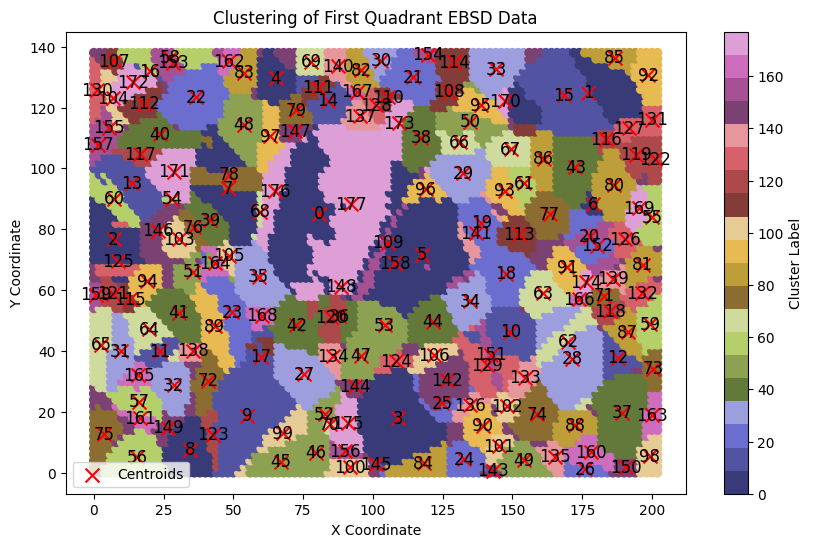

NCC values for each element in the dataset: [0.127243   0.10099317 0.79502603 ... 0.89322152 0.90273373 0.88412815]


In [2]:
import h5py
import numpy as np
import kikuchipy as kp
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def norm_data(data):
    """ Normalize data to have mean=0 and standard_deviation=1 """
    mean_data = np.mean(data)
    std_data = np.std(data, ddof=1)
    return (data - mean_data) / std_data

def ncc(data0, data1):
    """ Normalized cross-correlation coefficient between two data sets """
    return (1.0 / (data0.size - 1)) * np.sum(norm_data(data0) * norm_data(data1))

# Step 1: Load the EBSD data using h5py
file_path = '/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/input_data/large Specimen 1 averaging test 1 frame.h5oina'
with h5py.File(file_path, 'r') as file:
    processed_patterns_dataset = file['/1/EBSD/Data/Processed Patterns']
    ebsd_data = np.array(processed_patterns_dataset)
    X_coords = file['/1/EBSD/Data/X'][:]
    Y_coords = file['/1/EBSD/Data/Y'][:]

# Step 2: Determine the dimensions and split the data into quadrants
max_x = int(np.max(X_coords)) + 1
max_y = int(np.max(Y_coords)) + 1
mid_x = max_x // 2
mid_y = max_y // 2

# Extract the first quadrant
quadrant_1_indices = (X_coords < mid_x) & (Y_coords < mid_y)
quadrant_1 = ebsd_data[quadrant_1_indices]
X_coords_1 = X_coords[quadrant_1_indices]
Y_coords_1 = Y_coords[quadrant_1_indices]

# Step 3: Flatten each image and concatenate them into a single dataset for clustering
num_images_1, img_height, img_width = quadrant_1.shape
flattened_images_1 = quadrant_1.reshape(num_images_1, -1)

# Step 4: Perform clustering (e.g., K-means)
n_clusters = 178  # Define the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(flattened_images_1)
labels = kmeans.labels_

# Calculate the centroids in the coordinate space
centroids_coords = np.zeros((n_clusters, 2))
for cluster_idx in range(n_clusters):
    cluster_indices = labels == cluster_idx
    centroids_coords[cluster_idx, 0] = np.mean(X_coords_1[cluster_indices])
    centroids_coords[cluster_idx, 1] = np.mean(Y_coords_1[cluster_indices])

# Calculate evaluation metrics
silhouette_avg = silhouette_score(flattened_images_1, labels)
calinski_harabasz_avg = calinski_harabasz_score(flattened_images_1, labels)
davies_bouldin_avg = davies_bouldin_score(flattened_images_1, labels)
inertia = kmeans.inertia_

print(f"Silhouette Score: {silhouette_avg}")
print(f"Calinski-Harabasz Score: {calinski_harabasz_avg}")
print(f"Davies-Bouldin Score: {davies_bouldin_avg}")
print(f"Inertia: {inertia}")


# Print the centroids
# print("Centroids (in coordinate space):", centroids_coords)


cmap_custom = plt.get_cmap('tab20b')

# Set the figure size to 10 inches by 6 inches
plt.figure(figsize=(10, 6))

# Create a scatter plot of the coordinates colored by cluster labels
plt.scatter(X_coords_1, Y_coords_1, c=labels, cmap=cmap_custom, marker='o')
plt.colorbar(label='Cluster Label')

# Plot the centroids
plt.scatter(centroids_coords[:, 0], centroids_coords[:, 1], color='red', marker='x', s=100, label='Centroids')

# Annotate the centroids with their cluster indices
for i, (x, y) in enumerate(centroids_coords):
    plt.text(x, y, str(i), color='black', fontsize=12, ha='center', va='center')

plt.title('Clustering of First Quadrant EBSD Data')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()

plt.show()

# Step 6: Iterate over each cluster and analyze the clusters
# Initialize an array to store NCC values for each element in the dataset
ncc_values_all = np.zeros(len(labels))

# Iterate over each cluster
for cluster_idx in range(n_clusters):
    # Get the patterns and indices for the current cluster
    cluster_patterns = flattened_images_1[labels == cluster_idx]
    cluster_indices = np.where(labels == cluster_idx)[0]
    
    # Calculate the NCC between each pattern and the cluster centroid
    centroid_pattern = kmeans.cluster_centers_[cluster_idx]
    ncc_values_cluster = [ncc(centroid_pattern, pattern) for pattern in cluster_patterns]
    
    # Store these NCC values in the main array
    for idx, ncc_value in zip(cluster_indices, ncc_values_cluster):
        ncc_values_all[idx] = ncc_value

# Now, `ncc_values_all` contains the NCC value for each element in the dataset.
# You can print it, analyze it further, or use it as needed.
print("NCC values for each element in the dataset:", ncc_values_all)



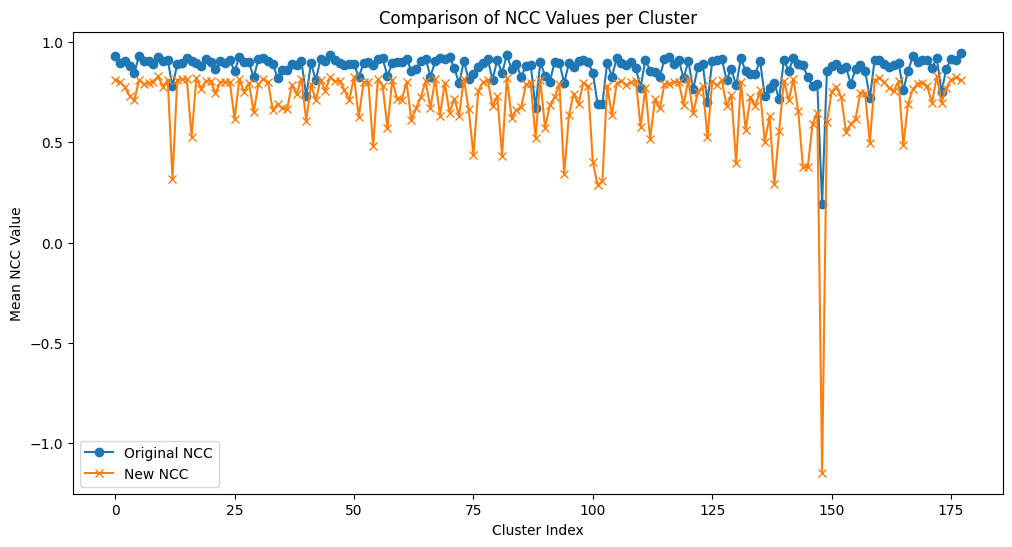

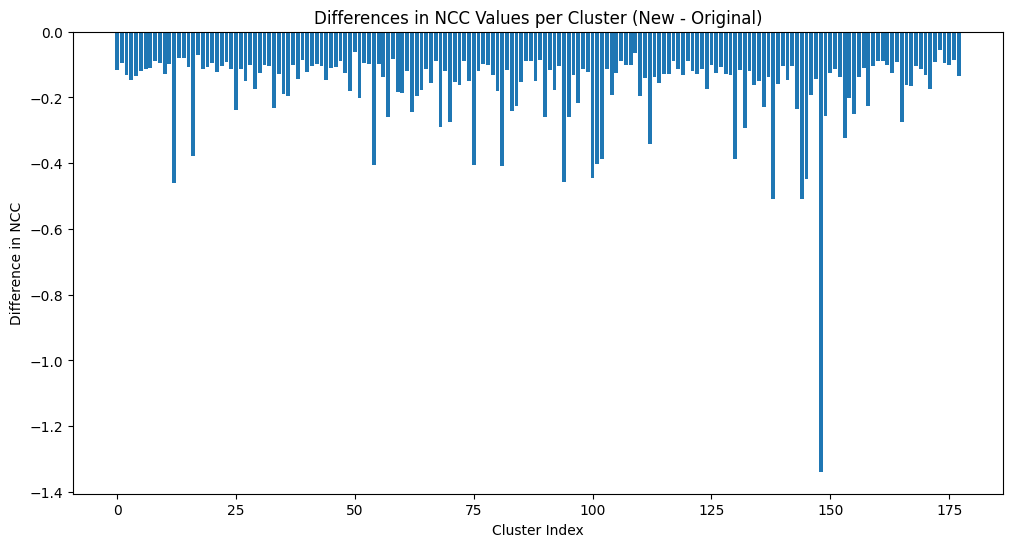

In [3]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

def norm_data(data):
    mean_data = np.mean(data)
    std_data = np.std(data, ddof=1)
    return (data - mean_data) / std_data

def ncc(data0, data1):
    return (1.0 / (data0.size - 1)) * np.sum(norm_data(data0) * norm_data(data1))

new_ncc_file_path = '/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/data_odciosa/large Specimen 1 averaging test 1 frame_1quadrantprocessed.h5oina'

with h5py.File(new_ncc_file_path, 'r') as file:
    new_ncc_values = file['/1/Data Processing/Pattern Matching/Data/Cross Correlation Coefficient'][:]
    new_ncc_quadrant_1 = new_ncc_values[quadrant_1_indices]

differences = []
mean_ncc_original = []
mean_ncc_new = []

for cluster_idx in range(kmeans.n_clusters):
    cluster_patterns = flattened_images_1[labels == cluster_idx]
    
    original_ncc = [ncc(kmeans.cluster_centers_[cluster_idx], pattern) for pattern in cluster_patterns]
    new_ncc = new_ncc_quadrant_1[labels == cluster_idx]
    
    mean_ncc_original.append(np.mean(original_ncc))
    mean_ncc_new.append(np.mean(new_ncc))
    differences.append(np.mean(new_ncc) - np.mean(original_ncc))

plt.figure(figsize=(12, 6))
plt.plot(range(kmeans.n_clusters), mean_ncc_original, label='Original NCC', marker='o')
plt.plot(range(kmeans.n_clusters), mean_ncc_new, label='New NCC', marker='x')
plt.title('Comparison of NCC Values per Cluster')
plt.xlabel('Cluster Index')
plt.ylabel('Mean NCC Value')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.bar(range(kmeans.n_clusters), differences)
plt.title('Differences in NCC Values per Cluster (New - Original)')
plt.xlabel('Cluster Index')
plt.ylabel('Difference in NCC')
plt.show()

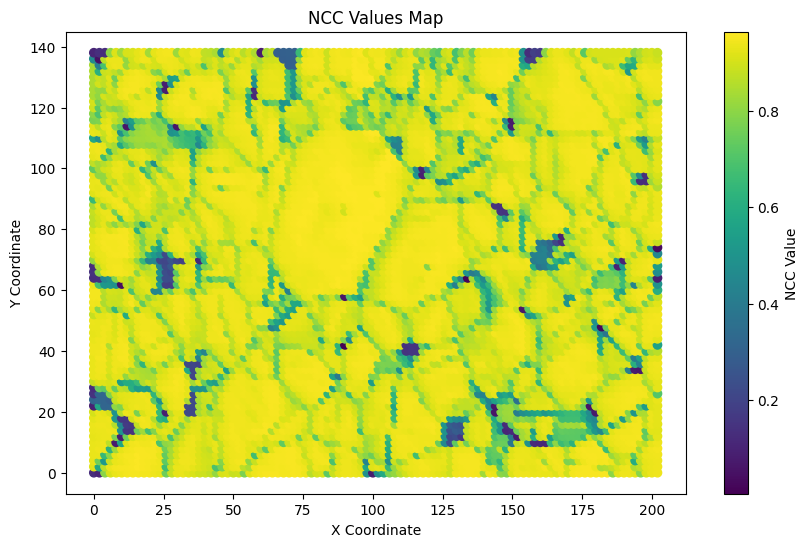

      X Coordinate  Y Coordinate  Cluster  NCC Value
0              0.0           0.0      148   0.127237
1              2.0           0.0      148   0.100988
2              4.0           0.0       56   0.794986
3              6.0           0.0       56   0.907052
4              8.0           0.0       56   0.932337
...            ...           ...      ...        ...
7135         194.0         138.0       85   0.807295
7136         196.0         138.0       92   0.850932
7137         198.0         138.0       92   0.893177
7138         200.0         138.0       92   0.902689
7139         202.0         138.0       92   0.884084

[7140 rows x 4 columns]


In [4]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Function for normalization and NCC calculation
def norm_data(data):
    return (data - np.mean(data)) / np.std(data, ddof=1)

def ncc(data0, data1):
    return np.mean(norm_data(data0) * norm_data(data1))

# Load EBSD data
file_path = '/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/input_data/large Specimen 1 averaging test 1 frame.h5oina'
with h5py.File(file_path, 'r') as file:
    ebsd_data = np.array(file['/1/EBSD/Data/Processed Patterns'])
    X_coords, Y_coords = file['/1/EBSD/Data/X'][:], file['/1/EBSD/Data/Y'][:]

# Data preprocessing
quadrant_1_indices = (X_coords < X_coords.max() // 2) & (Y_coords < Y_coords.max() // 2)
quadrant_1 = ebsd_data[quadrant_1_indices]
flattened_images_1 = quadrant_1.reshape(quadrant_1.shape[0], -1)

# Clustering
n_clusters = 178
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(flattened_images_1)
labels = kmeans.labels_

# Compute NCC for each element in relation to its cluster centroid
ncc_values_all = np.zeros(len(labels))
for cluster_idx in range(n_clusters):
    cluster_indices = np.where(labels == cluster_idx)[0]
    centroid_pattern = kmeans.cluster_centers_[cluster_idx]
    ncc_values_cluster = [ncc(centroid_pattern, flattened_images_1[idx]) for idx in cluster_indices]
    ncc_values_all[cluster_indices] = ncc_values_cluster

# NCC values map
plt.figure(figsize=(10, 6))
plt.scatter(X_coords[quadrant_1_indices], Y_coords[quadrant_1_indices], c=ncc_values_all, cmap='viridis', marker='o')
plt.colorbar(label='NCC Value')
plt.title('NCC Values Map')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

# Build NCC values table
import pandas as pd
ncc_table = pd.DataFrame({
    'X Coordinate': X_coords[quadrant_1_indices],
    'Y Coordinate': Y_coords[quadrant_1_indices],
    'Cluster': labels,
    'NCC Value': ncc_values_all
})
print(ncc_table)


Mean Absolute Error between calculated and new NCC values: 0.17415306624011676
      X Coordinate  Y Coordinate  Calculated NCC   New NCC
0              0.0           0.0        0.127237 -2.000000
1              2.0           0.0        0.100988 -2.000000
2              4.0           0.0        0.794986  0.823843
3              6.0           0.0        0.907052  0.823889
4              8.0           0.0        0.932337  0.824026
...            ...           ...             ...       ...
7135         194.0         138.0        0.807295  0.404984
7136         196.0         138.0        0.850932  0.799701
7137         198.0         138.0        0.893177  0.799941
7138         200.0         138.0        0.902689  0.800006
7139         202.0         138.0        0.884084  0.800065

[7140 rows x 4 columns]


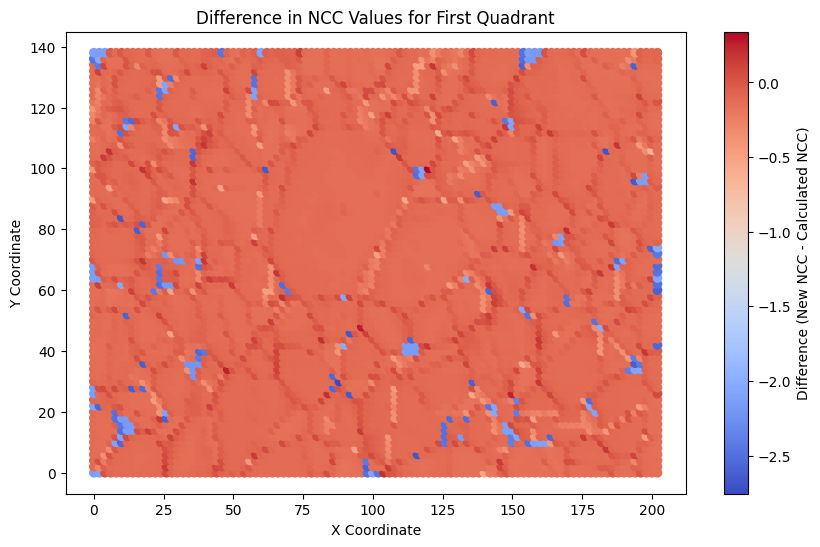

In [7]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Load new NCC values from the additional file
new_ncc_file_path = '/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/data_odciosa/large Specimen 1 averaging test 1 frame_1quadrantprocessed.h5oina'
with h5py.File(new_ncc_file_path, 'r') as file:
    new_ncc_values = file['/1/Data Processing/Pattern Matching/Data/Cross Correlation Coefficient'][:]
    X_coords_new = file['/1/EBSD/Data/X'][:]
    Y_coords_new = file['/1/EBSD/Data/Y'][:]

# Extract first quadrant from new NCC values to match the previously calculated NCC values
first_quadrant_indices_new = (X_coords_new < X_coords_new.max() // 2) & (Y_coords_new < Y_coords_new.max() // 2)
new_ncc_values_quadrant_1 = new_ncc_values[first_quadrant_indices_new]

# Ensure that the shapes of the calculated and new NCC values for the first quadrant match
if new_ncc_values_quadrant_1.shape[0] == ncc_values_all.shape[0]:
    # Calculate the mean absolute error for a quantitative comparison
    mae = mean_absolute_error(ncc_values_all, new_ncc_values_quadrant_1)
    print(f"Mean Absolute Error between calculated and new NCC values: {mae}")
    
    # Create a DataFrame to show the calculated and new NCC values side by side
    comparison_table = pd.DataFrame({
        'X Coordinate': X_coords[quadrant_1_indices],
        'Y Coordinate': Y_coords[quadrant_1_indices],
        'Calculated NCC': ncc_values_all,
        'New NCC': new_ncc_values_quadrant_1
    })
    print(comparison_table)

    # Plot the comparison of NCC values as a scatter plot to visualize differences
    plt.figure(figsize=(10, 6))
    plt.scatter(X_coords[quadrant_1_indices], Y_coords[quadrant_1_indices], c=new_ncc_values_quadrant_1 - ncc_values_all, cmap='coolwarm', marker='o')
    plt.colorbar(label='Difference (New NCC - Calculated NCC)')
    plt.title('Difference in NCC Values for First Quadrant')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.show()

else:
    print("The shapes of the calculated NCC values and the new NCC values for the first quadrant do not match. Please check data consistency.")


Calculated NCC - Mean: 0.8696542463327648 Std Dev: 0.1400208605481924
New NCC - Mean: 0.70283324 Std Dev: 0.455032
Mean Absolute Error (MAE): 0.17415306624011676
Correlation Coefficient: 0.7613357015525045


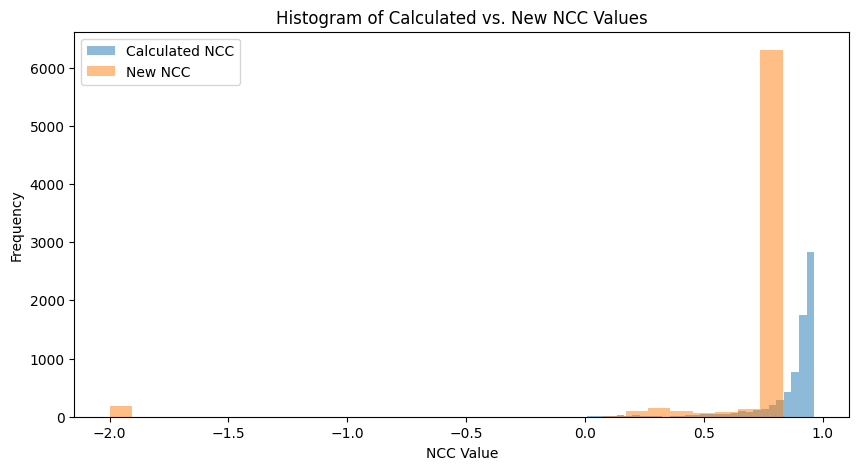

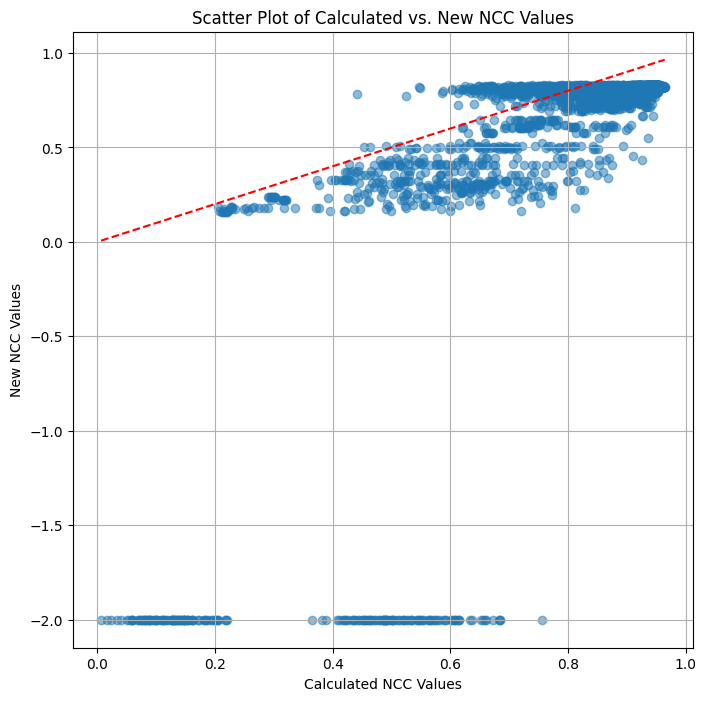

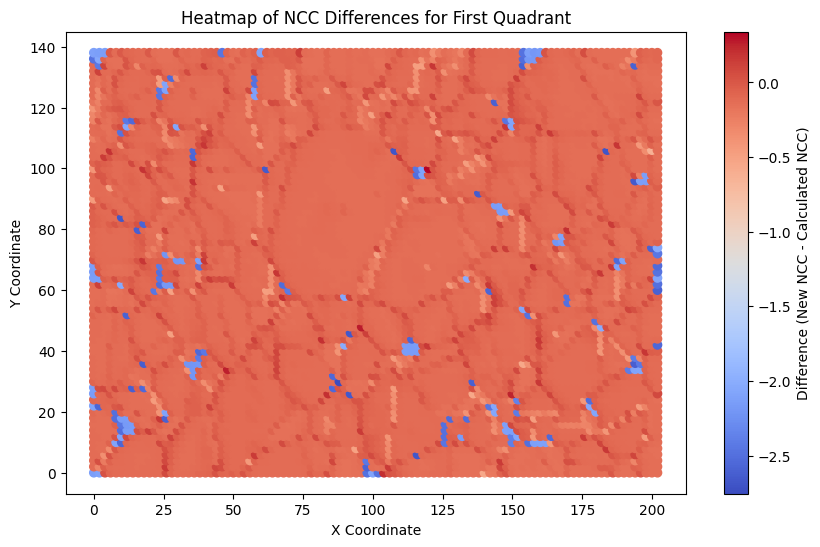

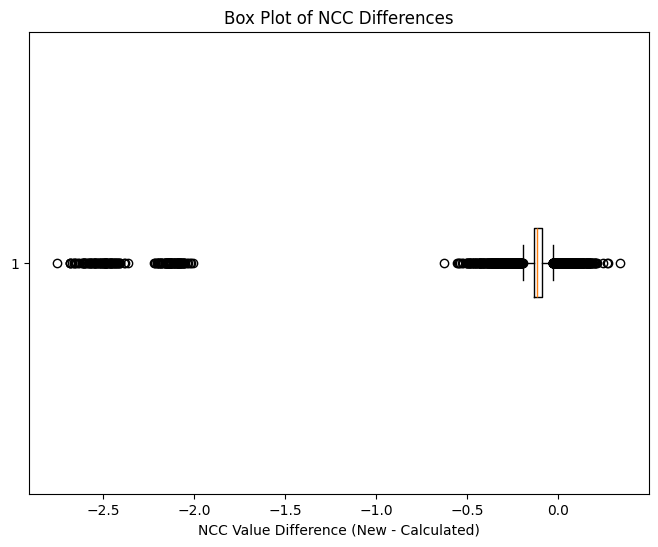

                    Metric     Value
0      Mean Calculated NCC  0.869654
1   Std Dev Calculated NCC  0.140021
2             Mean New NCC  0.702833
3          Std Dev New NCC  0.455032
4      Mean Absolute Error  0.174153
5  Correlation Coefficient  0.761336


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error

# Ensure necessary data is already loaded and available:
# - `ncc_values_all` (calculated NCC values for first quadrant)
# - `new_ncc_values_quadrant_1` (new NCC values for first quadrant)

# Statistical Metrics
mean_calculated = np.mean(ncc_values_all)
std_calculated = np.std(ncc_values_all)
mean_new = np.mean(new_ncc_values_quadrant_1)
std_new = np.std(new_ncc_values_quadrant_1)
mae = mean_absolute_error(ncc_values_all, new_ncc_values_quadrant_1)
correlation = np.corrcoef(ncc_values_all, new_ncc_values_quadrant_1)[0, 1]

print("Calculated NCC - Mean:", mean_calculated, "Std Dev:", std_calculated)
print("New NCC - Mean:", mean_new, "Std Dev:", std_new)
print("Mean Absolute Error (MAE):", mae)
print("Correlation Coefficient:", correlation)

# Plot 1: Histogram of Calculated vs. New NCC Values
plt.figure(figsize=(10, 5))
plt.hist(ncc_values_all, bins=30, alpha=0.5, label='Calculated NCC')
plt.hist(new_ncc_values_quadrant_1, bins=30, alpha=0.5, label='New NCC')
plt.xlabel("NCC Value")
plt.ylabel("Frequency")
plt.title("Histogram of Calculated vs. New NCC Values")
plt.legend()
plt.show()

# Plot 2: Scatter Plot of Calculated vs. New NCC Values
plt.figure(figsize=(8, 8))
plt.scatter(ncc_values_all, new_ncc_values_quadrant_1, alpha=0.5)
plt.plot([min(ncc_values_all), max(ncc_values_all)], [min(ncc_values_all), max(ncc_values_all)], 'r--')
plt.xlabel("Calculated NCC Values")
plt.ylabel("New NCC Values")
plt.title("Scatter Plot of Calculated vs. New NCC Values")
plt.grid()
plt.show()

# Plot 3: Heatmap of NCC Differences by Coordinates
ncc_diff = new_ncc_values_quadrant_1 - ncc_values_all
plt.figure(figsize=(10, 6))
plt.scatter(X_coords[quadrant_1_indices], Y_coords[quadrant_1_indices], c=ncc_diff, cmap='coolwarm', marker='o')
plt.colorbar(label='Difference (New NCC - Calculated NCC)')
plt.title("Heatmap of NCC Differences for First Quadrant")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.show()

# Plot 4: Box Plot of NCC Differences
plt.figure(figsize=(8, 6))
plt.boxplot(ncc_diff, vert=False)
plt.xlabel("NCC Value Difference (New - Calculated)")
plt.title("Box Plot of NCC Differences")
plt.show()

# Display Statistical Data Summary
stats_summary = pd.DataFrame({
    "Metric": ["Mean Calculated NCC", "Std Dev Calculated NCC", "Mean New NCC", "Std Dev New NCC", "Mean Absolute Error", "Correlation Coefficient"],
    "Value": [mean_calculated, std_calculated, mean_new, std_new, mae, correlation]
})
print(stats_summary)


Calculated NCC - Mean: 0.8570977604143819 Std Dev: 0.14604197434169122
New NCC - Mean: 0.7543739 Std Dev: 0.16990454
Mean Absolute Error (MAE): 0.12775633051231894
Correlation Coefficient: 0.6681969973316584


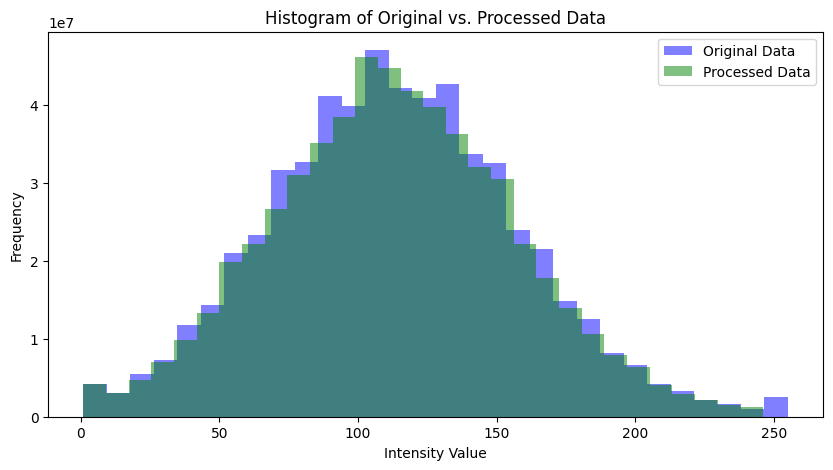

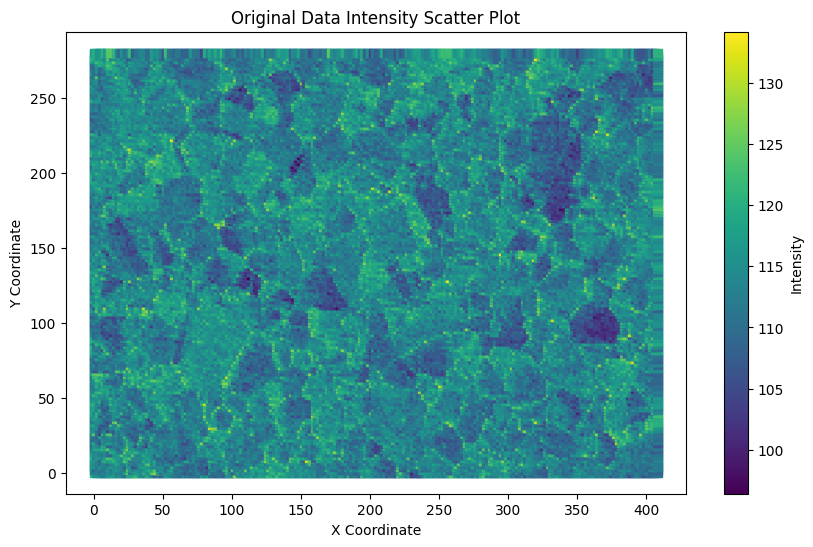

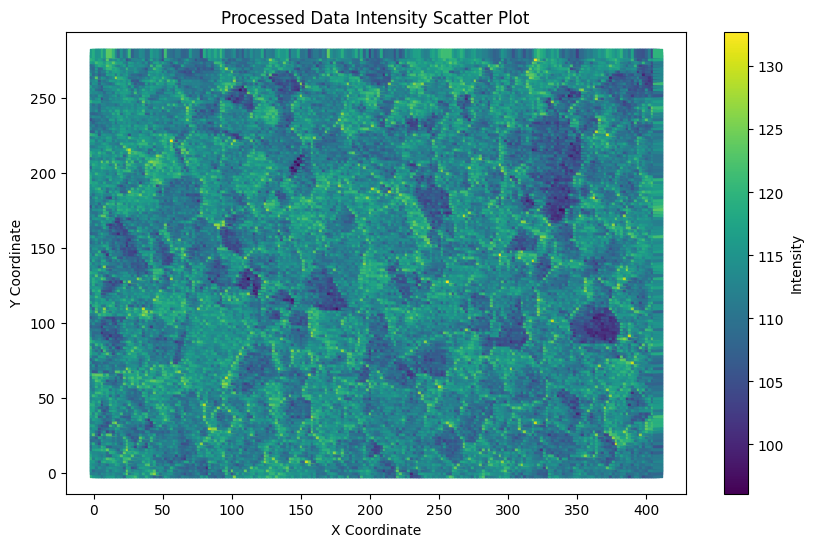

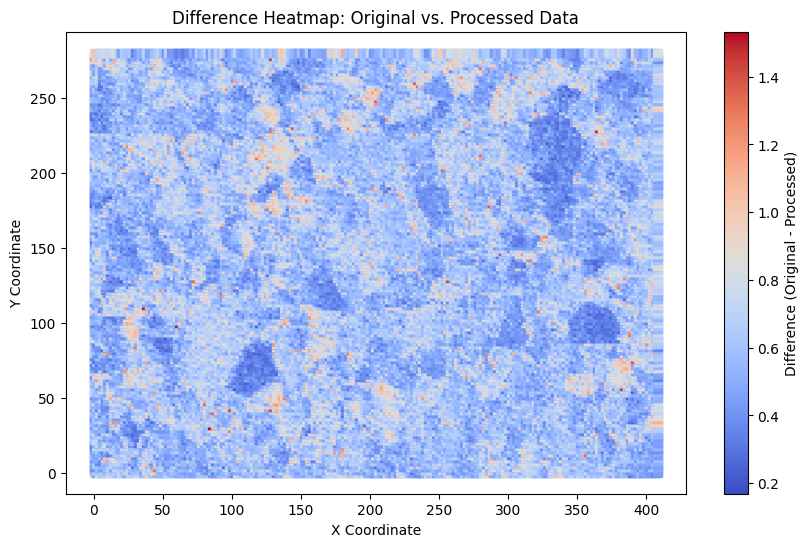

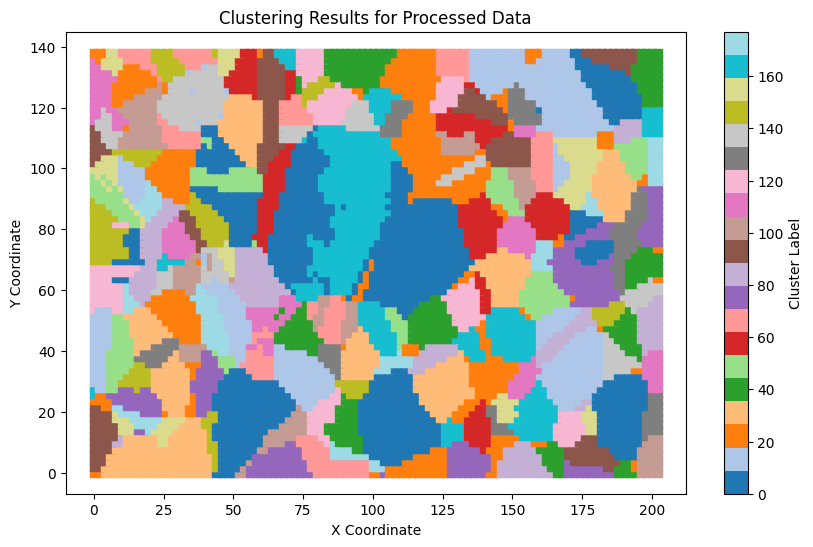

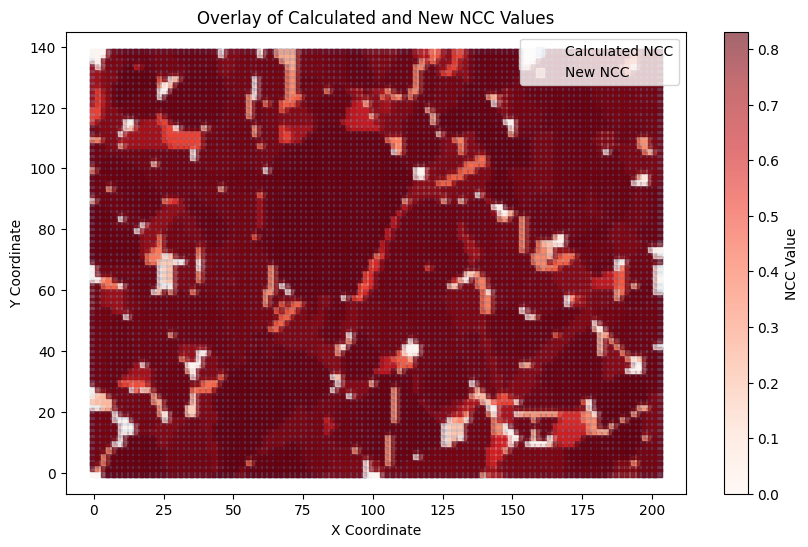

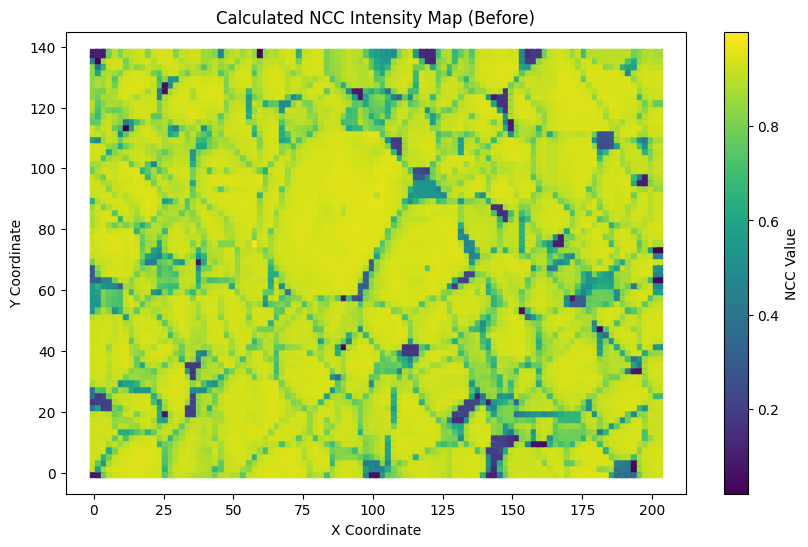

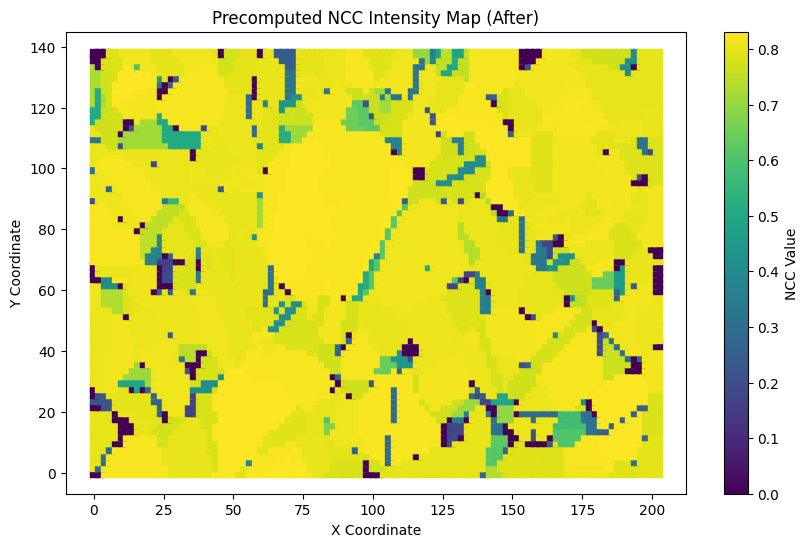

NCC values saved as 'ncc_values_calculated.csv' and 'ncc_values_new.csv'.


In [22]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error
from scipy.stats import zscore

# Function for normalization and NCC calculation
def norm_data(data):
    return (data - np.mean(data)) / np.std(data, ddof=1)

def ncc(data0, data1):
    return np.mean(norm_data(data0) * norm_data(data1))

# Load EBSD data
def load_ebsd_data(file_path):
    with h5py.File(file_path, 'r') as file:
        ebsd_data = np.array(file['/1/EBSD/Data/Processed Patterns'])
        X_coords, Y_coords = file['/1/EBSD/Data/X'][:], file['/1/EBSD/Data/Y'][:]
    return ebsd_data, X_coords, Y_coords

# Data cleaning: handling missing values and outliers
def clean_data(data):
    # Replace NaNs with column mean
    nan_mask = np.isnan(data)
    if np.any(nan_mask):
        data = np.where(nan_mask, np.nanmean(data, axis=0), data)
    
    # Remove outliers using z-score thresholding
    z_scores = zscore(data, axis=None)
    abs_z_scores = np.abs(z_scores)
    filtered_data = data[abs_z_scores < 3]  # Threshold of 3 for outlier removal
    
    # If filtered data size differs, replace outliers with mean value to preserve shape
    if filtered_data.size < data.size:
        filtered_data = np.where(abs_z_scores < 3, data, np.nanmean(data))
        
    return filtered_data

# Filter to the first quadrant
def extract_first_quadrant(data, X_coords, Y_coords):
    mid_x, mid_y = X_coords.max() // 2, Y_coords.max() // 2
    quadrant_1_indices = (X_coords < mid_x) & (Y_coords < mid_y)
    return data[quadrant_1_indices], X_coords[quadrant_1_indices], Y_coords[quadrant_1_indices]

# Perform K-means clustering
def perform_clustering(data, n_clusters=178):
    flattened_data = data.reshape(data.shape[0], -1)
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(flattened_data)
    return kmeans, kmeans.labels_, flattened_data

# Calculate NCC values for each element in relation to cluster centroids
def calculate_ncc_values(labels, flattened_data, kmeans):
    ncc_values = np.zeros(len(labels))
    for cluster_idx in range(kmeans.n_clusters):
        cluster_indices = np.where(labels == cluster_idx)[0]
        centroid_pattern = kmeans.cluster_centers_[cluster_idx]
        ncc_values_cluster = [ncc(centroid_pattern, flattened_data[idx]) for idx in cluster_indices]
        ncc_values[cluster_indices] = ncc_values_cluster
    return ncc_values

# Load precomputed NCC values and extract first quadrant
def load_precomputed_ncc(file_path, X_coords, Y_coords):
    with h5py.File(file_path, 'r') as file:
        new_ncc_values = file['/1/Data Processing/Pattern Matching/Data/Cross Correlation Coefficient'][:]
        X_coords_new, Y_coords_new = file['/1/EBSD/Data/X'][:], file['/1/EBSD/Data/Y'][:]
    first_quadrant_indices_new = (X_coords_new < X_coords_new.max() // 2) & (Y_coords_new < Y_coords_new.max() // 2)
    return new_ncc_values[first_quadrant_indices_new]

# Generate visualizations
def plot_histogram(ncc_values_calculated, ncc_values_new):
    plt.figure(figsize=(10, 5))
    plt.hist(ncc_values_calculated, bins=30, alpha=0.5, label='Calculated NCC')
    plt.hist(ncc_values_new, bins=30, alpha=0.5, label='New NCC')
    plt.xlabel("NCC Value")
    plt.ylabel("Frequency")
    plt.title("Histogram of Calculated vs. New NCC Values")
    plt.legend()
    plt.show()

def plot_scatter(ncc_values_calculated, ncc_values_new):
    plt.figure(figsize=(8, 8))
    plt.scatter(ncc_values_calculated, ncc_values_new, alpha=0.5)
    plt.plot([min(ncc_values_calculated), max(ncc_values_calculated)],
             [min(ncc_values_calculated), max(ncc_values_calculated)], 'r--')
    plt.xlabel("Calculated NCC Values")
    plt.ylabel("New NCC Values")
    plt.title("Scatter Plot of Calculated vs. New NCC Values")
    plt.grid()
    plt.show()

def plot_heatmap(X_coords, Y_coords, ncc_diff):
    plt.figure(figsize=(10, 6))
    plt.scatter(X_coords, Y_coords, c=ncc_diff, cmap='coolwarm', marker='o')
    plt.colorbar(label='Difference (New NCC - Calculated NCC)')
    plt.title("Heatmap of NCC Differences for First Quadrant")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.show()

def plot_boxplot(ncc_diff):
    plt.figure(figsize=(8, 6))
    plt.boxplot(ncc_diff, vert=False)
    plt.xlabel("NCC Value Difference (New - Calculated)")
    plt.title("Box Plot of NCC Differences")
    plt.show()

def plot_original_vs_processed_histograms(original_data, processed_data):
    plt.figure(figsize=(10, 5))
    plt.hist(original_data.flatten(), bins=30, alpha=0.5, label='Original Data', color='blue')
    plt.hist(processed_data.flatten(), bins=30, alpha=0.5, label='Processed Data', color='green')
    plt.xlabel("Intensity Value")
    plt.ylabel("Frequency")
    plt.title("Histogram of Original vs. Processed Data")
    plt.legend()
    plt.show()

def plot_intensity_scatter(X_coords, Y_coords, data, title="Data Intensity Scatter Plot"):
    # Ensure data is a 1D array matching X_coords and Y_coords
    if data.size != X_coords.size:
        raise ValueError("Data size does not match coordinate size.")
    plt.figure(figsize=(10, 6))
    plt.scatter(X_coords, Y_coords, c=data, cmap='viridis', marker=',')
    plt.colorbar(label='Intensity')
    plt.title(title)
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.show()


def plot_difference_heatmap(X_coords, Y_coords, original_data, processed_data):
    # Calculate the difference and ensure it's flattened
    difference = (original_data - processed_data).flatten()
    if difference.size != X_coords.size:
        raise ValueError("Difference size does not match coordinate size.")
    plt.figure(figsize=(10, 6))
    plt.scatter(X_coords, Y_coords, c=difference, cmap='coolwarm', marker=',')
    plt.colorbar(label='Difference (Original - Processed)')
    plt.title("Difference Heatmap: Original vs. Processed Data")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.show()

def plot_clustering_heatmap(X_coords, Y_coords, labels, title="Clustering Results"):
    # Ensure labels are a 1D array matching X and Y coordinates
    labels = np.array(labels).flatten()
    if labels.size != X_coords.size:
        raise ValueError("Labels size does not match coordinate size.")
    plt.figure(figsize=(10, 6))
    plt.scatter(X_coords, Y_coords, c=labels, cmap='tab20', marker=',')
    plt.colorbar(label='Cluster Label')
    plt.title(title)
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.show()

def plot_ncc_overlay(X_coords, Y_coords, ncc_calculated, ncc_new):
    # Flatten NCC values to match X and Y coordinates
    ncc_calculated = np.array(ncc_calculated).flatten()
    ncc_new = np.array(ncc_new).flatten()
    if ncc_calculated.size != X_coords.size or ncc_new.size != X_coords.size:
        raise ValueError("NCC values size does not match coordinate size.")
    plt.figure(figsize=(10, 6))
    plt.scatter(X_coords, Y_coords, c=ncc_calculated, cmap='Blues', marker=',', alpha=0.6, label='Calculated NCC')
    plt.scatter(X_coords, Y_coords, c=ncc_new, cmap='Reds', marker=',', alpha=0.6, label='New NCC')
    plt.colorbar(label='NCC Value')
    plt.title("Overlay of Calculated and New NCC Values")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.legend()
    plt.show()

def plot_ncc_map(X_coords, Y_coords, ncc_values, title="NCC Intensity Map"):
    """
    Plots an NCC map using X and Y coordinates with color intensity based on NCC values.
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(X_coords, Y_coords, c=ncc_values, cmap='viridis', marker=',')
    plt.colorbar(label='NCC Value')
    plt.title(title)
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.show()

# Clip NCC values to the [0, 1] range
def clean_ncc_values(ncc_values):
    """
    Ensures NCC values are between 0 and 1 by clipping.
    """
    return np.clip(ncc_values, 0, 1)

# Main function
def main():
    # Step 1: Load EBSD data
    ebsd_file_path = '/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/input_data/large Specimen 1 averaging test 1 frame.h5oina'
    ebsd_data, X_coords, Y_coords = load_ebsd_data(ebsd_file_path)

    # Step 2: Data Cleaning
    ebsd_data_cleaned = clean_data(ebsd_data)

    # Step 3: Extract mean intensity per pattern
    mean_intensity_original = np.mean(ebsd_data, axis=(1, 2))
    mean_intensity_processed = np.mean(ebsd_data_cleaned, axis=(1, 2))

    # Step 4: Extract first quadrant
    quadrant_1_data, X_coords_1, Y_coords_1 = extract_first_quadrant(ebsd_data_cleaned, X_coords, Y_coords)

    # Step 5: Perform clustering
    n_clusters = 178
    kmeans, labels, flattened_images_1 = perform_clustering(quadrant_1_data, n_clusters=n_clusters)

    # Step 6: Calculate NCC values for each element
    ncc_values_calculated = calculate_ncc_values(labels, flattened_images_1, kmeans)

    # Step 7: Load precomputed NCC values and extract first quadrant
    new_ncc_file_path = '/Users/jedrzejkurzepa/Projects/EBSD_analyze_app/data_odciosa/large Specimen 1 averaging test 1 frame_1quadrantprocessed.h5oina'
    ncc_values_new = load_precomputed_ncc(new_ncc_file_path, X_coords, Y_coords)

    # Step 8: Clean NCC values to ensure they are within the 0 to 1 range
    ncc_values_calculated = clean_ncc_values(ncc_values_calculated)
    ncc_values_new = clean_ncc_values(ncc_values_new)

    # Step 9: Statistical analysis
    mean_calculated = np.mean(ncc_values_calculated)
    std_calculated = np.std(ncc_values_calculated)
    mean_new = np.mean(ncc_values_new)
    std_new = np.std(ncc_values_new)
    mae = mean_absolute_error(ncc_values_calculated, ncc_values_new)
    correlation = np.corrcoef(ncc_values_calculated, ncc_values_new)[0, 1]

    print("Calculated NCC - Mean:", mean_calculated, "Std Dev:", std_calculated)
    print("New NCC - Mean:", mean_new, "Std Dev:", std_new)
    print("Mean Absolute Error (MAE):", mae)
    print("Correlation Coefficient:", correlation)

    # Step 10: Visualizations
    # Plot original vs processed histograms
    plot_original_vs_processed_histograms(ebsd_data, ebsd_data_cleaned)

    # Plot intensity scatter plots for original and processed data
    plot_intensity_scatter(X_coords, Y_coords, mean_intensity_original, title="Original Data Intensity Scatter Plot")
    plot_intensity_scatter(X_coords, Y_coords, mean_intensity_processed, title="Processed Data Intensity Scatter Plot")

    # Plot difference heatmap (original vs processed)
    plot_difference_heatmap(X_coords, Y_coords, mean_intensity_original, mean_intensity_processed)

    # Plot clustering results heatmap
    plot_clustering_heatmap(X_coords_1, Y_coords_1, labels, title="Clustering Results for Processed Data")

    # Plot overlay of calculated and precomputed NCC values
    plot_ncc_overlay(X_coords_1, Y_coords_1, ncc_values_calculated, ncc_values_new)

    # Plot NCC maps before and after processing
    plot_ncc_map(X_coords_1, Y_coords_1, ncc_values_calculated, title="Calculated NCC Intensity Map (Before)")
    plot_ncc_map(X_coords_1, Y_coords_1, ncc_values_new, title="Precomputed NCC Intensity Map (After)")

# Run the program
if __name__ == "__main__":
    main()


In [24]:
import pandas as pd

def load_ncc_values_as_separate_dataframes(calculated_path, new_path):
    """
    Loads NCC values from CSV files into two separate DataFrames.

    Parameters:
    - calculated_path (str): Path to the CSV file containing calculated NCC values.
    - new_path (str): Path to the CSV file containing new (precomputed) NCC values.

    Returns:
    - calculated_df (pd.DataFrame): DataFrame containing calculated NCC values.
    - new_df (pd.DataFrame): DataFrame containing new (precomputed) NCC values.
    """
    # Load the calculated NCC values into a DataFrame
    calculated_df = pd.read_csv(calculated_path)
    
    # Load the new NCC values into a DataFrame
    new_df = pd.read_csv(new_path)
    
    return calculated_df, new_df

# Example usage:
calculated_df, new_df = load_ncc_values_as_separate_dataframes('ncc_values_calculated.csv', 'ncc_values_new.csv')
print("Calculated NCC DataFrame:\n", calculated_df)
print("\nNew NCC DataFrame:\n", new_df)




Calculated NCC DataFrame:
       Calculated NCC
0           0.076516
1           0.089089
2           0.775544
3           0.896810
4           0.925218
...              ...
7135        0.790813
7136        0.833452
7137        0.877396
7138        0.889838
7139        0.867999

[7140 rows x 1 columns]

New NCC DataFrame:
        New NCC
0     0.000000
1     0.000000
2     0.823843
3     0.823889
4     0.824026
...        ...
7135  0.404984
7136  0.799701
7137  0.799941
7138  0.800006
7139  0.800065

[7140 rows x 1 columns]


In [31]:
calculated_df.describe()

,Calculated NCC
count,7140.000000
mean,0.857098
std,0.146052
min,0.021010
25%,0.852666
50%,0.913599
75%,0.933270
max,0.999950


In [30]:
new_df.describe()

,New NCC
count,7140.000000
mean,0.754374
std,0.169916
min,0.000000
25%,0.791348
50%,0.808009
75%,0.819912
max,0.830955


Calculated NCC Statistics:
           Calculated NCC
count        7140.000000
mean            0.857098
std             0.146052
min             0.021010
25%             0.852666
50%             0.913599
75%             0.933270
max             0.999950
skew           -3.036687
kurtosis       10.318870

New NCC Statistics:
               New NCC
count     7140.000000
mean         0.754374
std          0.169916
min          0.000000
25%          0.791348
50%          0.808009
75%          0.819912
max          0.830955
skew        -3.282193
kurtosis    10.026534


/var/folders/ty/5ms_sgfx2gzgt3kljnjcpcn40000gn/T/ipykernel_1188/120158912.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_xticklabels(['Calculated NCC', 'New NCC'])


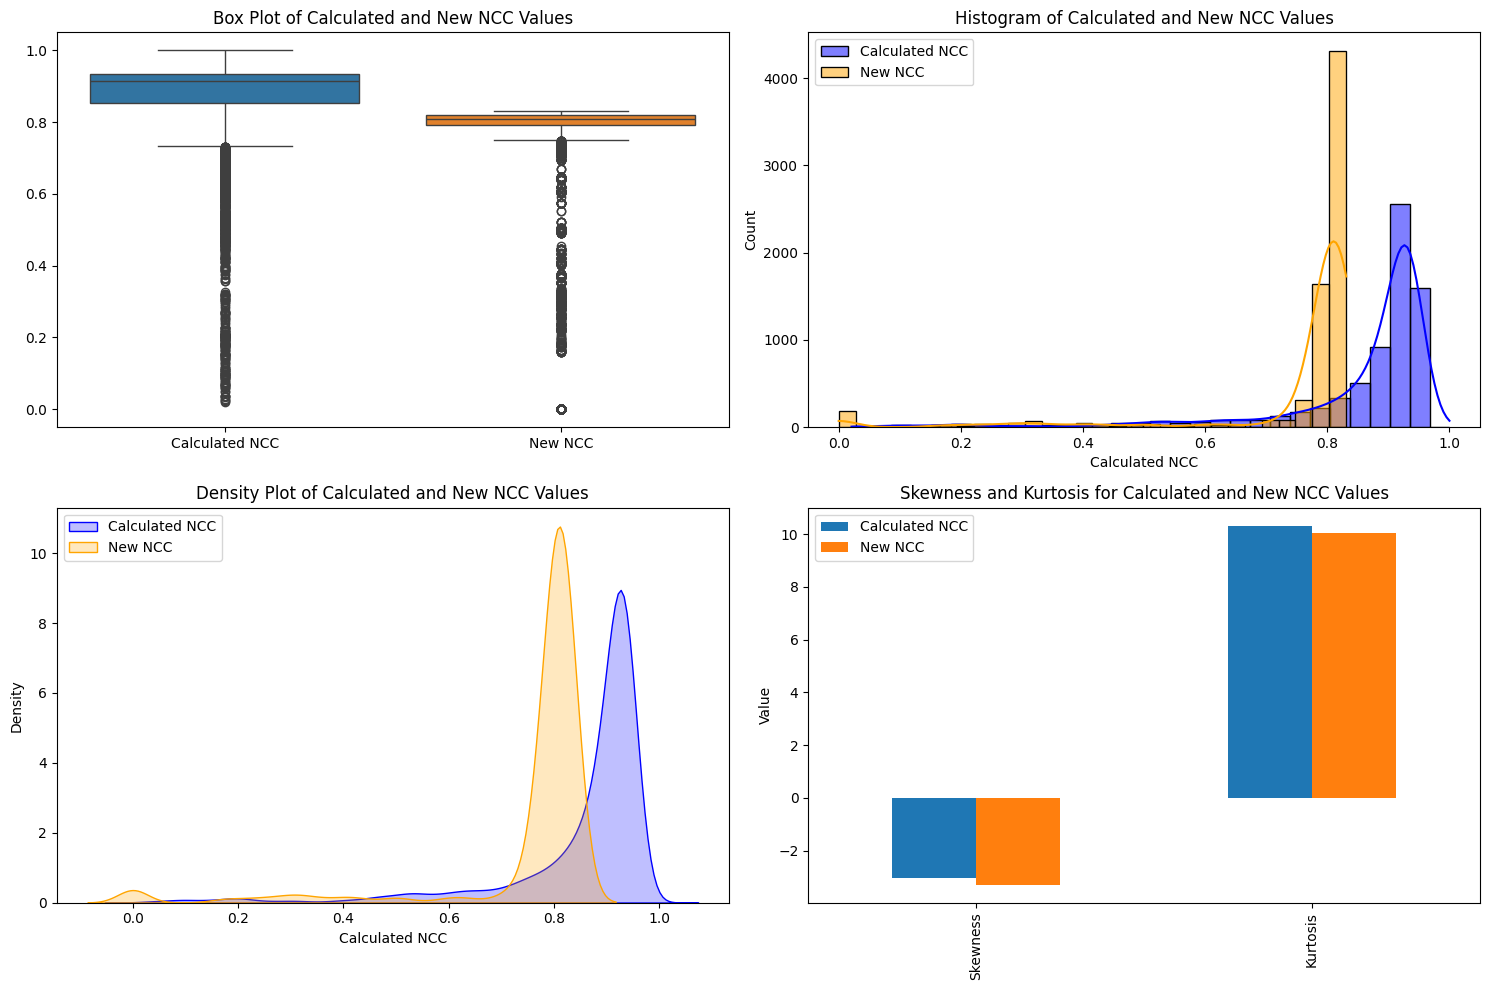

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def load_ncc_values_as_separate_dataframes(calculated_path, new_path):
    calculated_df = pd.read_csv(calculated_path)
    new_df = pd.read_csv(new_path)
    return calculated_df, new_df

def calculate_statistics(df):
    stats = df.describe()
    stats.loc['skew'] = df.skew()
    stats.loc['kurtosis'] = df.kurtosis()
    return stats

def plot_statistics(calculated_df, new_df):
    # Set up the figure and axes for subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Box Plot
    sns.boxplot(data=[calculated_df['Calculated NCC'], new_df['New NCC']], ax=axes[0, 0])
    axes[0, 0].set_xticklabels(['Calculated NCC', 'New NCC'])
    axes[0, 0].set_title("Box Plot of Calculated and New NCC Values")
    
    # Histogram
    sns.histplot(calculated_df['Calculated NCC'], bins=30, color='blue', kde=True, ax=axes[0, 1], label="Calculated NCC")
    sns.histplot(new_df['New NCC'], bins=30, color='orange', kde=True, ax=axes[0, 1], label="New NCC")
    axes[0, 1].set_title("Histogram of Calculated and New NCC Values")
    axes[0, 1].legend()
    
    # Density Plot
    sns.kdeplot(calculated_df['Calculated NCC'], color='blue', fill=True, ax=axes[1, 0], label="Calculated NCC")
    sns.kdeplot(new_df['New NCC'], color='orange', fill=True, ax=axes[1, 0], label="New NCC")
    axes[1, 0].set_title("Density Plot of Calculated and New NCC Values")
    axes[1, 0].legend()

    # Bar Plot for Skewness and Kurtosis
    stats = pd.DataFrame({
        "Calculated NCC": [calculated_df['Calculated NCC'].skew(), calculated_df['Calculated NCC'].kurtosis()],
        "New NCC": [new_df['New NCC'].skew(), new_df['New NCC'].kurtosis()]
    }, index=["Skewness", "Kurtosis"])
    
    stats.plot(kind="bar", ax=axes[1, 1])
    axes[1, 1].set_title("Skewness and Kurtosis for Calculated and New NCC Values")
    axes[1, 1].set_ylabel("Value")
    
    plt.tight_layout()
    plt.show()

# Example usage:
calculated_df, new_df = load_ncc_values_as_separate_dataframes('ncc_values_calculated.csv', 'ncc_values_new.csv')
calculated_stats = calculate_statistics(calculated_df)
new_stats = calculate_statistics(new_df)

print("Calculated NCC Statistics:\n", calculated_stats)
print("\nNew NCC Statistics:\n", new_stats)

# Plot statistics
plot_statistics(calculated_df, new_df)
